In [2]:
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import mlflow
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Approach

In [2]:
mlflow.set_experiment('First Experiment')
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

2026/01/08 12:26:55 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/08 12:26:55 INFO mlflow.store.db.utils: Updating database tables
2026/01/08 12:26:55 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/08 12:26:55 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/08 12:26:55 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/08 12:26:55 INFO alembic.runtime.migration: Will assume non-transactional DDL.


The cifar-10 dataset according to documentation it has 10 classes with 6000 images per class.<br>
I will choose 5 of the total classes which are airplane, automobile, bird, cat, deer.

In [113]:
(X_train, y_train), (X_test,y_test) = cifar10.load_data()

32 (height) X 32 (width) X 3 (colours RGB) = 3072 numbers. <br> So every picture is a vector of 3072 elements.

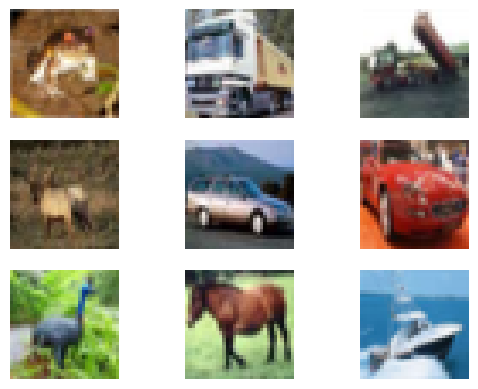

In [4]:
# Plot first 9 images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.axis('off')

plt.show()

In [117]:
# Keep only the selected classes = ['airplane', 'automobile', 'bird', 'cat', 'deer']
selected_classes = [0,1, 2, 3, 4] # these are the indexes

mask = np.isin(y_train.flatten(), selected_classes)

X_train_sub = X_train[mask]
y_train_sub = y_train[mask]

# Test mask
test_mask = np.isin(y_test.flatten(), selected_classes)
X_test_sub = X_test[test_mask]
y_test_sub = y_test[test_mask]

In [119]:
print(f'The independet variables training shape (selected classes) is : {X_train_sub.shape}')
print(f'The target variable training shape (selected classes) is : {y_train_sub.shape}')

print(f'The independet variables testing shape (selected classes) is : {X_test_sub.shape}')
print(f'The target testing shape (selected classes) is : {y_test_sub.shape}')

The independet variables training shape (selected classes) is : (25000, 32, 32, 3)
The target variable training shape (selected classes) is : (25000, 1)
The independet variables testing shape (selected classes) is : (5000, 32, 32, 3)
The target testing shape (selected classes) is : (5000, 1)


For simplicity, i justscale the pixel intensities down to the 0-1 range by dividing them by 255.0.

In [8]:
# Flatten images: (32,32,3) -> 3072 features
X_train_flat = X_train_sub.reshape(len(X_train_sub), -1).astype('float32') / 255.0
X_test_flat  = X_test_sub.reshape(len(X_test_sub), -1).astype('float32') / 255.0

Normalize the images to a number from 0 to 1. Image has 3 channels (R,G,B) and each value in the channel can range from 0 to 255. <br>Hence to normalize in 0-->1 range, we need to divide it by 255

Since there is a problem with high dimensionality i will use PCA to reduce the dimensions (3071 -> 200).

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)  # reduce features from 3072 → 200
X_train_pca = pca.fit_transform(X_train_flat.astype('float32'))
X_test_pca = pca.transform(X_test_flat.astype('float32'))

In [24]:
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier,
    AdaBoostClassifier
)
from sklearn.svm import SVC

models = {"Logistic Regression": LogisticRegression(),
          'SVM': SVC()}

param_grid = {"Logistic Regression": {},
    'SVM':{}}


Start tuning the Logistic Regression.

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.75      0.71      1000
           2       0.42      0.42      0.42      1000
           3       0.41      0.41      0.41      1000
           4       0.49      0.46      0.47      1000
           5       0.44      0.42      0.43      1000

    accuracy                           0.49      5000
   macro avg       0.49      0.49      0.49      5000
weighted avg       0.49      0.49      0.49      5000



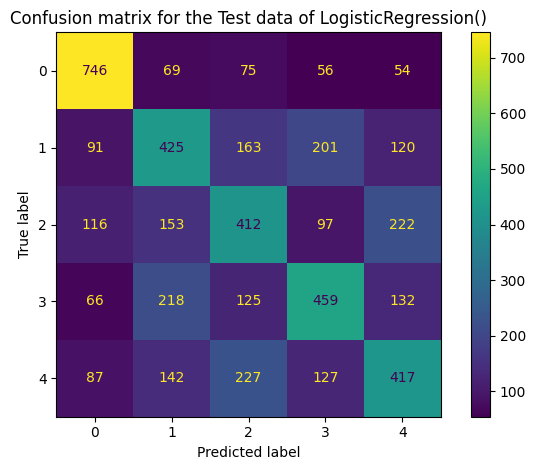

Start tuning the SVM.

Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.87      0.85      1000
           2       0.52      0.55      0.54      1000
           3       0.49      0.51      0.50      1000
           4       0.57      0.58      0.58      1000
           5       0.59      0.50      0.54      1000

    accuracy                           0.60      5000
   macro avg       0.60      0.60      0.60      5000
weighted avg       0.60      0.60      0.60      5000



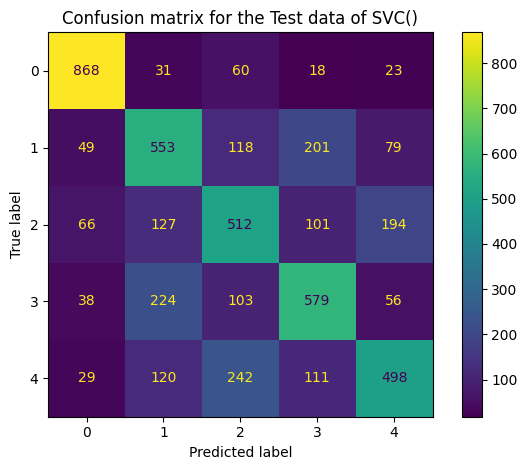

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

# Empty dictionary to save all of the hyperparameter tuning results for each parameter.
result = {}


for model_name, model in models.items():
    print(f"Start tuning the {model_name}.") # only for debugging purposes
    clf = model  # get the model
    hype = param_grid[model_name] # get the hyperparameters for hyperparameter tuning
    
    # grid search cv to get the best combination of hyperparameters
    grid  = GridSearchCV(clf,  
                    hype, 
                    scoring='f1', 
                    n_jobs = -1, # To use the whole cpu and get faster results.
                    cv=5).fit(X_train_pca, y_train_sub)
    
    # update the result dict
    result[model_name] = {
        "best_params": grid.best_params_, # Parameter setting that gave the best results on the hold out data.
        "best_f1": grid.best_score_,   # Mean cross-validated score of the best_estimator. 
        "best_model": grid.best_estimator_ # the best set of parameters
    }
    
    # print(f'\nThe best cross validation score (f1) for the {model_name} is : {grid.best_score_}\n\n')
    best_model = grid.best_estimator_ # use the best estimetor to predict on the testing set 

    # ---- Test set evaluation ----
    y_pred = best_model.predict(X_test_pca)

    print("\nClassification Report:")
    print(classification_report(y_test_sub, y_pred))

    # Plot Confusion matrix 
    cm = confusion_matrix(y_test_sub, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion matrix for the Test data of {model}')
    plt.tight_layout()
    plt.show()

In [ ]:
for i, element in enumerate(models):
    model_name = element[0]
    model = element[1]
    report = result[i]
    
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("model", model_name)
        mlflow.log_metric('accuracy', report['accuracy'])
        mlflow.log_metric('recall', report['recall'])
        mlflow.log_metric('f1', report['f1'])    

🏃 View run Logistic Regression at: http://127.0.0.1:5000/#/experiments/1/runs/71b8af4bb95b4252bd331bfe4c1b9c52
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
🏃 View run SVM at: http://127.0.0.1:5000/#/experiments/1/runs/17facd80d94e4baa9502d3aa94120d46
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


So SVM has higher accuracy and from these two models i would choose that one for better performance.

# Neural Network Approach

Let 's build an ANN (Artificial Neural Network)

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

# create the model
ann = models.Sequential([
        layers.Flatten(input_shape=(3072,)), # is like a preprocess to flat arrays of images in 1D
        layers.Dense(3000, activation='relu'),
        layers.Dense(1000, activation='relu'),
        layers.Dense(10, activation='softmax')    
    ])

# compile the model
ann.compile(optimizer='SGD', # SGD to reduce the ram needs
              loss='sparse_categorical_crossentropy', # i use this loss function since there are sparse labels
              metrics=['accuracy'])

ann.fit(X_train_flat, y_train_sub, epochs=5)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.4264 - loss: 1.3538
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.4948 - loss: 1.2069
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.5205 - loss: 1.1484
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.5412 - loss: 1.1100
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5570 - loss: 1.0769


In [29]:
ann.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3000)           │     9,219,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     3,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        10,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,230,012 (46.65 MB)

 Trainable params: 12,230,010 (46.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [30]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = ann.predict(X_test_flat)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test_sub, y_pred_classes))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report: 
               precision    recall  f1-score   support

           1       0.50      0.94      0.66      1000
           2       0.67      0.14      0.24      1000
           3       0.48      0.10      0.16      1000
           4       0.52      0.56      0.54      1000
           5       0.37      0.61      0.47      1000

    accuracy                           0.47      5000
   macro avg       0.51      0.47      0.41      5000
weighted avg       0.51      0.47      0.41      5000



In [31]:
report = classification_report(y_test_sub, y_pred_classes,output_dict=True)
report

{'1': {'precision': 0.5048335123523093,
  'recall': 0.94,
  'f1-score': 0.6568832983927324,
  'support': 1000.0},
 '2': {'precision': 0.6651162790697674,
  'recall': 0.143,
  'f1-score': 0.2353909465020576,
  'support': 1000.0},
 '3': {'precision': 0.48258706467661694,
  'recall': 0.097,
  'f1-score': 0.16153205661948378,
  'support': 1000.0},
 '4': {'precision': 0.5194805194805194,
  'recall': 0.56,
  'f1-score': 0.5389797882579404,
  'support': 1000.0},
 '5': {'precision': 0.3740875912408759,
  'recall': 0.615,
  'f1-score': 0.46520423600605143,
  'support': 1000.0},
 'accuracy': 0.471,
 'macro avg': {'precision': 0.5092209933640179,
  'recall': 0.471,
  'f1-score': 0.4115980651556531,
  'support': 5000.0},
 'weighted avg': {'precision': 0.5092209933640178,
  'recall': 0.471,
  'f1-score': 0.41159806515565306,
  'support': 5000.0}}

In [ ]:
with mlflow.start_run(run_name=model_name):
        mlflow.log_metrics({
            'accuracy': report['accuracy'],
            'recall': report['macro avg']['recall'],
            'f1_score_macro': report['macro avg']['f1-score']
        })  

🏃 View run ANN at: http://127.0.0.1:5000/#/experiments/1/runs/fd13bede73b34bd7877699bbf61c45b2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


# CNN Approach (Convolutional Neural Network)

In [97]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
num_classes = 5
def create_cnn():
    model = Sequential()

    # Conv Block 1
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Conv Block 2
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Conv Block 3
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Classifier
    model.add(Flatten()) # convert to 1D
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

model = create_cnn()

#print model
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 30, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,277,253 (4.87 MB)

 Trainable params: 1,277,253 (4.87 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # works with integer labels
    metrics=['accuracy']
)


In [120]:
# Keep original shape
X_train_sub.shape  # (25000, 32, 32, 3)

model.fit(
    X_train_sub,
    y_train_sub,  # flatten labels to (25000,)
    batch_size=200,
    epochs=5,
    validation_split=0.2
)


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 614ms/step - accuracy: 0.4487 - loss: 1.2417 - val_accuracy: 0.5984 - val_loss: 0.9965
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 619ms/step - accuracy: 0.6359 - loss: 0.9201 - val_accuracy: 0.6702 - val_loss: 0.8551
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 621ms/step - accuracy: 0.6885 - loss: 0.8135 - val_accuracy: 0.7326 - val_loss: 0.7333
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 610ms/step - accuracy: 0.7225 - loss: 0.7350 - val_accuracy: 0.7376 - val_loss: 0.7217
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 610ms/step - accuracy: 0.7454 - loss: 0.6798 - val_accuracy: 0.7594 - val_loss: 0.6568


In [ ]:
results = model.evaluate(X_test_sub, y_test_sub, batch_size=250)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.7480 - loss: 0.6523


In [127]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(X_test_sub)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test_sub, y_pred_classes))

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.79      0.80      1000
           1       0.89      0.96      0.92      1000
           2       0.58      0.73      0.64      1000
           3       0.71      0.69      0.70      1000
           4       0.80      0.58      0.67      1000

    accuracy                           0.75      5000
   macro avg       0.76      0.75      0.75      5000
weighted avg       0.76      0.75      0.75      5000



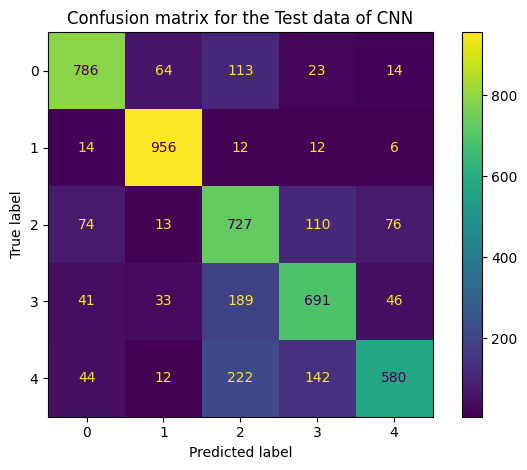

In [129]:
# Plot Confusion matrix 
cm = confusion_matrix(y_test_sub, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f'Confusion matrix for the Test data of CNN')
plt.tight_layout()
plt.show()

So CNN has by far the highest accuracy (78,4%) in contrast with ΑΝΝ. <br> The next highest accuracy has the SVM with accuracy 0.6.